In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
%matplotlib notebook
VegMap = 'C:\\Users\\User\\Google Drive\\FishIsland_Outputs\\VegMap/'

Out_Path = 'C:\\Users\\User\\Google Drive\\PhD_Thesis/'

In [2]:

veg_class = gpd.read_file(VegMap+'cp_veg_la.shp')
# veg = gpd.read_file(VegMap+'cavm_all polygon.shp')
veg = gpd.read_file(VegMap+'Bio_Unioin.shp')
land = gpd.read_file(VegMap+'cp_coast_la.shp')
veg = veg.loc[veg['COUNTRY']!='wa'].copy()
land = land.loc[land['COUNTRY']!='wa'].copy()
land = land.dissolve(by='COUNTRY')


data = pd.read_csv(VegMap+'Arctic Fluxes_EC_Tower_1970_to_2020.csv')
data = gpd.GeoDataFrame(
                    data,
                    geometry=gpd.points_from_xy(data.Longitude, data.Latitude),
                    crs='WGS1984'
                        )

data = data.to_crs(veg.crs)
land = land.to_crs(veg.crs)
veg_class = veg_class.to_crs(veg.crs)

In [3]:
from geopy.geocoders import MapBox
import folium

access_token="pk.eyJ1IjoianVuZXNwYWNlYm9vdHMiLCJhIjoiY2twY3g4aXloMWFlcDJzbXN3aG95aG5uZiJ9.mFiJt0MIfL1MiJ2rB2xhKQ"

if access_token == "":
    print('Enter your access token to continue')
else:
    geolocator = MapBox(api_key=access_token)
    print('Mapbox Goelocator Loaded')

Mapbox Goelocator Loaded


In [4]:
# Wa = (Just_Wet.dissolve(by='ZONE').area/1e6).round(1)
# (Wa/Wa.sum()*100).round()

In [5]:
labels=['A','B','C','D','E','Ice','Sub-Arctic','Non-Arctic']
ZONE = [1,2,3,4,5,7,6,0]
for z,l in zip(ZONE,labels):
#     print(z,l)
    veg.loc[veg['ZONE']==z,'BioClimate Zone']=l
    
colors = [
'#f1eef6',
'#bdc9e1',
'#74a9cf',
'#2b8cbe',
'#045a8d',
'white',
'#f5f5dc',
'#d9fffe']

Combined_Color = {key:value for key,value in zip(labels,colors)}
Combined_Color

{'A': '#f1eef6',
 'B': '#bdc9e1',
 'C': '#74a9cf',
 'D': '#2b8cbe',
 'E': '#045a8d',
 'Ice': 'white',
 'Sub-Arctic': '#f5f5dc',
 'Non-Arctic': '#d9fffe'}

In [6]:
Arctic1 = gpd.sjoin(data, veg, how="left")
Arctic = gpd.sjoin(Arctic1, veg_class, how="left",rsuffix='Extra')


Arctic = Arctic.loc[Arctic['ZONE']<6]
Arctic['BioClimate Zone']=Arctic['BioClimate Zone'].fillna(labels[-1])
Arctic = Arctic.loc[Arctic['BioClimate Zone']!='Non-Arctic']
print(Arctic.loc[Arctic['CH4']].groupby(['BioClimate Zone','Country']).count()['type'].unstack().fillna(0).astype(int))#[:-1])
# Tab
print(Arctic.groupby(['BioClimate Zone','Country']).count()['type'].unstack().fillna(0).astype(int).sum(axis=1))
print(Arctic.groupby(['BioClimate Zone','Country']).count()['type'].unstack().fillna(0).astype(int).sum()/
Arctic.groupby(['BioClimate Zone','Country']).count()['type'].unstack().fillna(0).astype(int).sum().sum())


Arctic.groupby(['BioClimate Zone','Country']).count()['type'].unstack().fillna(0).astype(int)



Country          Canada  Greenland  Russia  United States of America
BioClimate Zone                                                     
C                     0          1       0                         5
D                     1          0       2                         2
E                     3          0       1                         7
BioClimate Zone
B     2
C    13
D     9
E    22
dtype: int64
Country
Canada                      0.217391
Greenland                   0.108696
Norway                      0.065217
Russia                      0.108696
United States of America    0.500000
dtype: float64


Country,Canada,Greenland,Norway,Russia,United States of America
BioClimate Zone,,,,,
B,1,0,1,0,0
C,3,3,2,0,5
D,1,2,0,3,3
E,5,0,0,2,15


In [7]:

def plot_point(Map,X,Y,Popup_Text,Color='red',Radius=5,Opacity=.75,LineColor='black',LineWidth=.15):
    folium.CircleMarker(
        # The coordiatnates
        location=[X,Y],
        # Text description
        popup=Popup_Text,
        # sets the fill color for the point
        fill_color=Color,
        # Size of the marker
        radius=Radius,
        # Opacity of the circle
        fill_opacity = Opacity,
        # Sets the line color for the edge
        color=LineColor,
        # Width of the border line
        line_weight=LineWidth,
    ).add_to(Map)
    
    
tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(access_token)
# Map3 = folium.Map(location=[UBC_Geography.latitude,UBC_Geography.longitude],
#                  zoom_start=12,
    
Map4 = folium.Map(
location=[40,0],
zoom_start=3,
tiles=tileurl, 
attr='Mapbox')

# print(data)
for i,pt in Arctic.iterrows():
#     print(pr)
    point = plot_point(Map4,pt.Latitude,pt.Longitude,pt.Reference)


Map4

In [8]:
# print(Arctic.loc[Arctic['CH4']==True].count()['type']/Arctic.count()['type'])

print(Arctic.loc[Arctic['Site_Name']=='Upad','Biome'])

95    Moist-wet sedge tundra
Name: Biome, dtype: object


In [9]:
veg['area']=veg.area
veg=veg.loc[veg['ZONE']!=6]
veg=veg.loc[veg['ZONE']!=0]
Grp = veg.groupby(['BioClimate Zone','COUNTRY']).sum()['area'].unstack().fillna(0)/1e6

veg=veg.dissolve(by='ZONE',aggfunc='first')

Tb = (Grp/Grp.sum().sum()*100).round(1)[:-1]#.droplevel(level=0,axis=1)#.drop('COUNTYR')#.loc[:, 'Country'] 
# print(Tb.sum())
# print(Tb.sum(axis=1))

# TB['Dist']=

T = Tb.T
T['Sum'] = Tb.sum()

All = T.T
All['Dist']=Tb.sum(axis=1)
All['Dist']=All['Dist']/All['Dist'][:-1].sum()*100
All.round(1)

# (All['Dist']/All['Dist'][:-1].sum()*100).round()[:-1]#.sum()
print(33.8+29.2)

63.0


In [13]:
# Arctic.groupby('BioClimate Zone').sum()

print(Arctic.loc[((Arctic['Country']=='United States of America')&(Arctic['Country']=='United States of America')),
                 ['Site_Name','Latitude','Longitude','Country','Biome']].round(1))
# fig,ax=plt.subplots()
# Arctic.plot(ax=ax)
Arctic.loc[Arctic['Site_Name']=='Prudhoe Bay Wet Sedge','Reference'].values#,'Site']='This'
Arctic.loc[Arctic['Site_Name']=='Fish Island','Site']='This'
Arctic.loc[Arctic['Site']!='This','Site']='Not This'

# print(Arctic.columns)


                             Site_Name  Latitude  Longitude  \
12                         Barrow-CMDL      71.3     -156.6   
13                       Central Marsh      71.3     -156.6   
14                          Barrow-BEO      71.3     -156.6   
15                          Barrow-BES      71.3     -156.6   
16                         NGEE Barrow      71.3     -156.6   
18                             Atqasuk      70.5     -157.4   
20               Prudhoe Bay Wet Sedge      70.1     -148.6   
21                       Sag Riverside      69.5     -148.2   
25                        Happy Valley      69.2     -148.8   
35                  Toolik Lake (lake)      68.6     -149.6   
36               Toolik Lake (Wetland)      68.6     -149.6   
39       Imnavait, Alaska heath tundra      68.6     -149.3   
40     Imnavait, Alaska tussock tundra      68.6     -149.3   
41   Imnavait, Alaska wet sedge tundra      68.6     -149.3   
43                              Ivotuk      68.5     -1

<IPython.core.display.Javascript object>


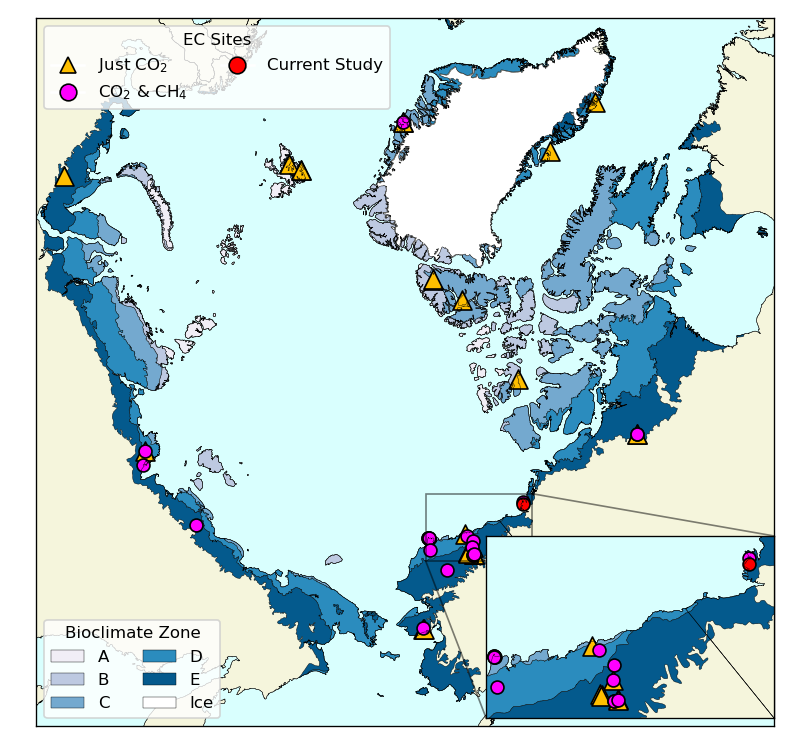

A
B
C
D
E
Ice


In [14]:

fig,ax=plt.subplots(1,figsize=(6.75,6.25))

Combined_Patches=[]

axins = ax.inset_axes([0.61, 0.0, 0.39, 0.28])


kwargs = {'facecolor':'#f5f5dc',
                 'edgecolor':'k',
                 'linewidth':0.25,
                 'label':l}
land.plot(ax=ax,**kwargs)
land.plot(ax=axins,**kwargs)


for l in labels[:-2]:
    print(l)
    kwargs = {'facecolor':Combined_Color[l],
                     'edgecolor':'k',
                     'linewidth':0.25,
                     'label':l,
#                      'fontsize':10
             }
    veg.loc[veg['BioClimate Zone']==l].plot(ax=ax,
            **kwargs
                 )
    veg.loc[veg['BioClimate Zone']==l].plot(ax=axins,
            **kwargs
                 )
    Combined_Patches.append(mpatches.Patch(**kwargs))
leg = ax.legend(handles=(Combined_Patches),ncol=2,
          loc='lower left',title='Bioclimate Zone',fontsize=10)
# ax2=ax.twinx()

P2 = []
kwargs={'color':[1,.75,0],'marker':'^','markersize':130,'edgecolor':'k','label':'Measured $CH_4$'}
Arctic.loc[((Arctic['CH4']==False)&(Arctic['Site']!='This'))].plot(ax=ax,**kwargs)
Arctic.loc[((Arctic['CH4']==False)&(Arctic['Site']!='This'))].plot(ax=axins,**kwargs)
kwargs={'color':'w','markeredgecolor':'k','markerfacecolor':[1,.75,0],'marker':'^','markersize':10,'label':'Just CO$_2$'}
legend_elements = [Line2D([0], [0],**kwargs)]


kwargs={'color':[1,0,1],'marker':'o','markersize':60,'edgecolor':'k','label':'No $CH_4$'}
Arctic.loc[((Arctic['CH4']==True)&(Arctic['Site']!='This'))].plot(ax=ax,**kwargs)
Arctic.loc[((Arctic['CH4']==True)&(Arctic['Site']!='This'))].plot(ax=axins,**kwargs)
kwargs={'color':'w','markeredgecolor':'k','markerfacecolor':[1,0,1],'marker':'o','markersize':10,'label':'CO$_2$ & CH$_4$'}
legend_elements.append(Line2D([0], [0],**kwargs))



kwargs={'color':[1,0,0],'marker':'o','markersize':60,'edgecolor':'k','label':'No $CH_4$'}
Arctic.loc[((Arctic['CH4']==True)&(Arctic['Site']=='This'))].plot(ax=ax,**kwargs)
Arctic.loc[((Arctic['CH4']==True)&(Arctic['Site']=='This'))].plot(ax=axins,**kwargs)
kwargs={'color':'w','markeredgecolor':'k','markerfacecolor':[1,0,0],'marker':'o','markersize':10,'label':'Current Study'}
legend_elements.append(Line2D([0], [0],**kwargs))

ax.legend(handles=legend_elements, loc='upper left',fontsize=10,ncol=2,title='EC Sites')

plt.gca().add_artist(leg)
plt.rcParams['legend.title_fontsize'] = 12




kwargs = {'facecolor':'None',
                 'edgecolor':'k',
                 'linewidth':0.25,
                 'label':l}
land.plot(ax=ax,**kwargs)
land.plot(ax=axins,**kwargs)


ax.set_facecolor('#d9fffe')

ax.set_xlim(-2.5e6,3.75e6)
ax.set_ylim(-3.5e6,2.5e6)

ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)


x1, x2, y1, y2 = 0.8e6, 1.70e6, -2.1e6, -1.53e6

axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.get_yaxis().set_visible(False)
axins.get_xaxis().set_visible(False)
axins.set_facecolor('#d9fffe')

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.show()

plt.tight_layout()
plt.savefig(Out_Path+'Fig1.png',dpi=600)

<IPython.core.display.Javascript object>


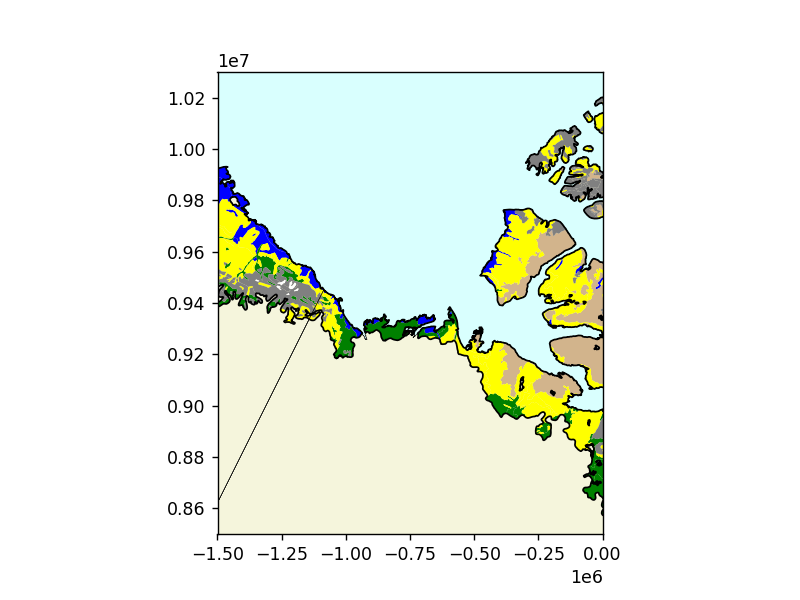

In [24]:

A = veg_class.loc[veg_class['PHYSIOG']<18].groupby('PHYSIOG')['Shape_Area'].sum()

# veg_class = veg_class.to_crs('EPSG:3581')
# land = land.to_crs('EPSG:3581')


fig,ax=plt.subplots()
kwargs = {'facecolor':'#f5f5dc',
                 'edgecolor':'k',
                 'linewidth':0.25,
                 'label':l}

land.plot(ax=ax,**kwargs)

veg_class.loc[((veg_class['PHYSIOG']>=12)&(veg_class['PHYSIOG']<=14))].plot(ax=ax,color='blue')
veg_class.loc[((veg_class['PHYSIOG']>=9)&(veg_class['PHYSIOG']<=10))].plot(ax=ax,color='green')
veg_class.loc[((veg_class['PHYSIOG']==4)|(veg_class['PHYSIOG']==6))].plot(ax=ax,color='tan')
veg_class.loc[((veg_class['PHYSIOG']==2)|(veg_class['PHYSIOG']==5)
              |(veg_class['PHYSIOG']==7)|(veg_class['PHYSIOG']==8))].plot(ax=ax,color='yellow')
veg_class.loc[((veg_class['PHYSIOG']==1)|(veg_class['PHYSIOG']==3)
              |(veg_class['PHYSIOG']==15)|(veg_class['PHYSIOG']==16)|
               (veg_class['PHYSIOG']==17))].plot(ax=ax,color='grey')
veg_class.loc[((veg_class['PHYSIOG']==18))].plot(ax=ax,color='white')

veg_class.loc[((veg_class['PHYSIOG']>=1)&(veg_class['PHYSIOG']<=18))].dissolve().plot(ax=ax,color='None',edgecolor='k')


(A/A.sum()*100).round(1)

kwargs = {'facecolor':'None',
                 'edgecolor':'k',
                 'linewidth':0.25,
                 'label':l}

land.plot(ax=ax,**kwargs)


ax.set_xlim(-1.5e6,0)
ax.set_ylim(8.5e6,1.03e7)
ax.set_facecolor('#d9fffe')
